In [79]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


# Прогнозирование уровня средней заработной платы в России

In [80]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [81]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда

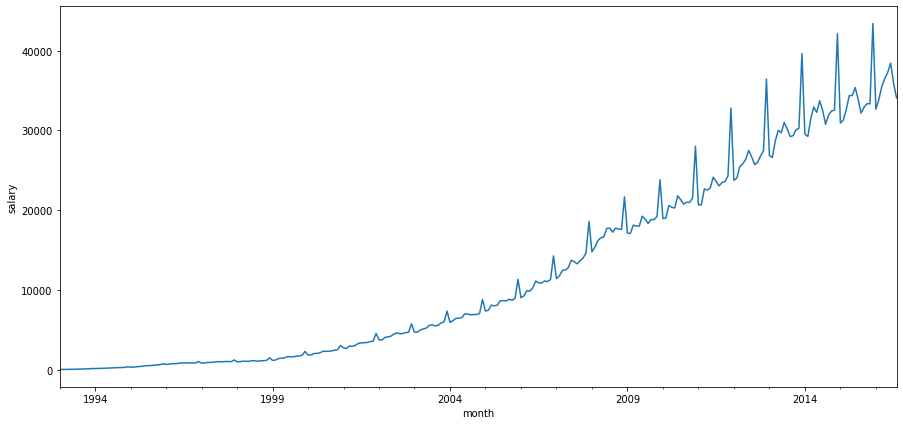

In [82]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('salary')
pylab.show()

Данные имеют тренд (плавное долгосрочное увеличение уровня), сезонность и дисперсия значений в начале значительно меньше дисперсии значений в конце. В

Для построения модели, обощающей временной ряд требуется обеспечить стационарность и для этого необходимо:

Стабилизировать дисперсию в течении всего временного ряда.
Провести дифференцирование (в т.ч. сезонное).

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


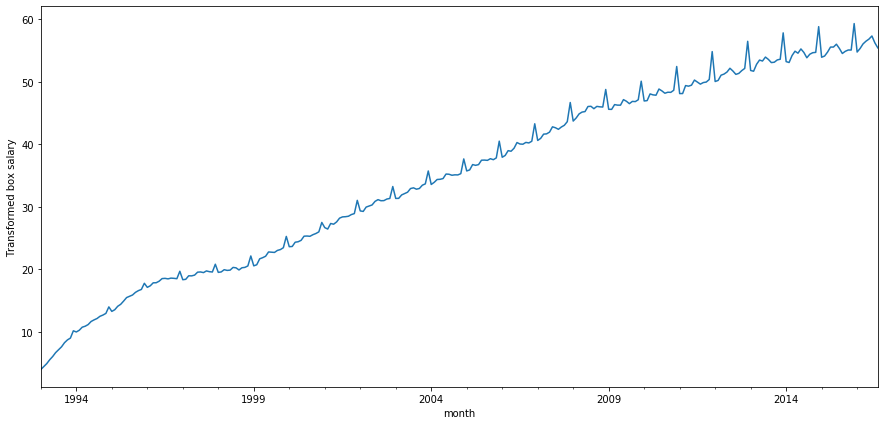

In [83]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed box salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

Как видно из графика, дисперсия уменьшилась, но стационарность еще не достигнута. Критерий Дики-Фуллера отвергает гипотезу нестационарности, визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

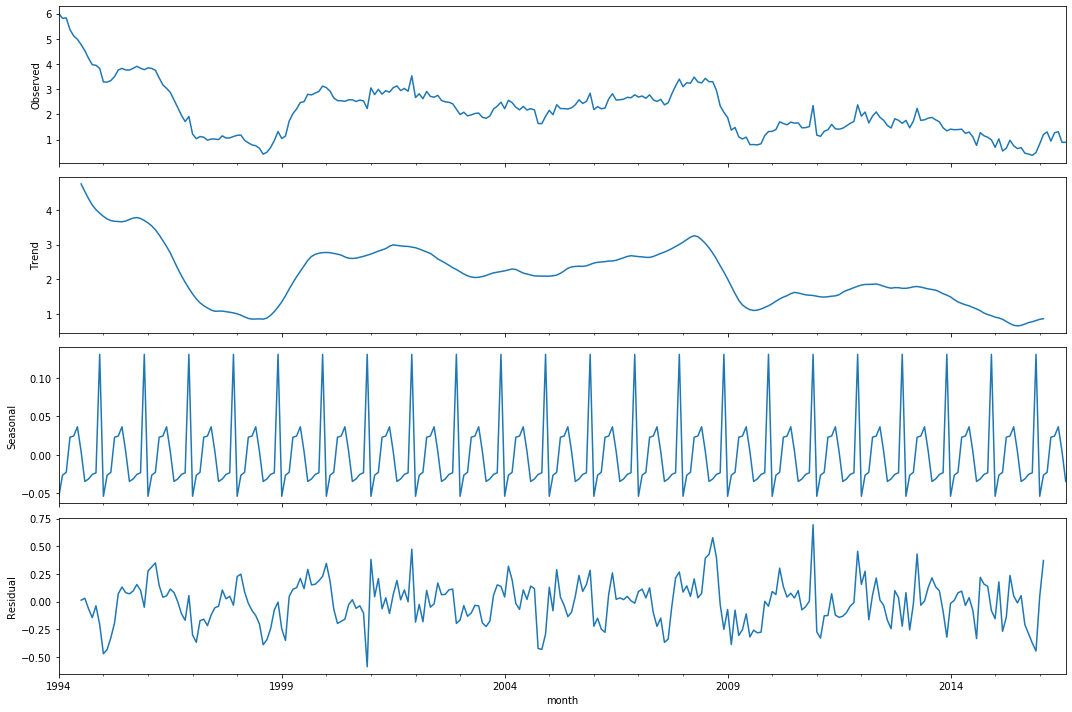

In [84]:
salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff.dropna())[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

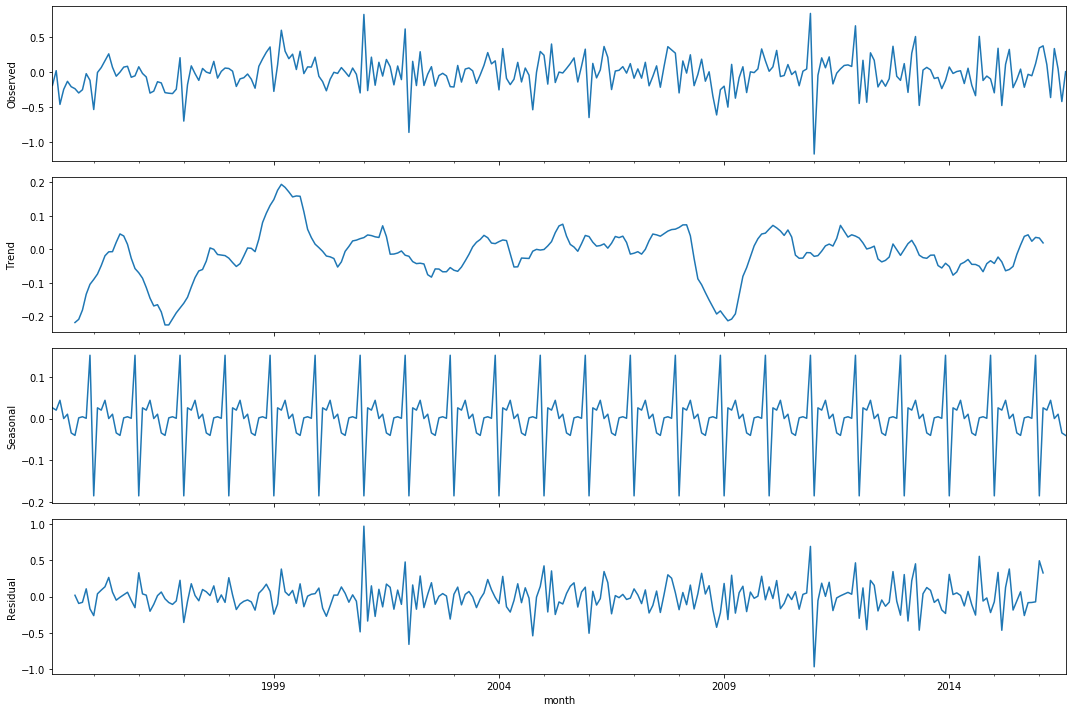

In [85]:
salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2.dropna())[1])

salary['WAG_C_M_box_diff3'] = salary.WAG_C_M_box_diff2 - salary.WAG_C_M_box_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff3.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff3.dropna())[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. Порядок дифференцирования d=1, D=1.

### Подбор модели. Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда: 

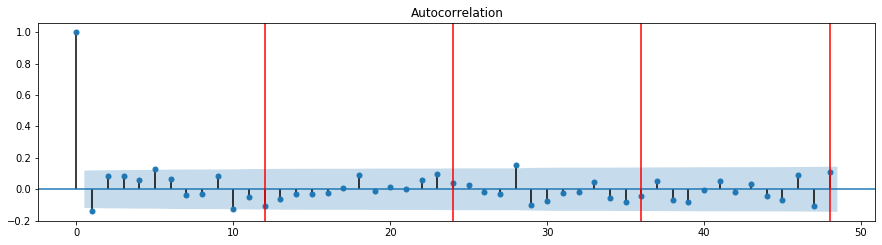

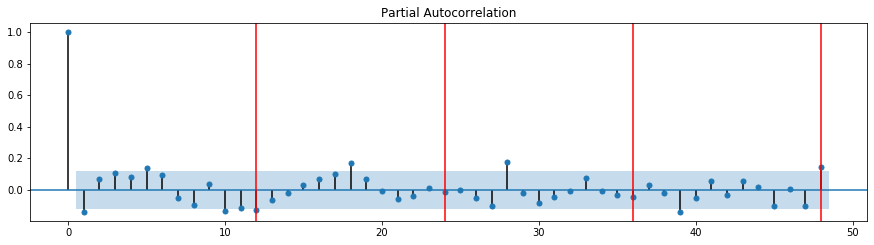

In [86]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)
for i in range(12, 60, 12):
    plt.axvline(i, -0.3, 1, c='r')
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)
for i in range(12, 60, 12):
    plt.axvline(i, -0.3, 1, c='r')
pylab.show()

Начальные приближения: Q=0, q=5, P=4, p=5

In [87]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [88]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [89]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

LinAlgError: LU decomposition error.

In [91]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
70  (2, 2, 0, 0) -21.488595
71  (2, 2, 1, 0) -21.473461
75  (2, 3, 0, 0) -21.091450
76  (2, 3, 1, 0) -20.398611
72  (2, 2, 2, 0) -20.309067


Параметры лучшей модели:

In [92]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                  15.744
Date:                            Fri, 03 Apr 2020   AIC                            -21.489
Time:                                    21:24:30   BIC                             -3.478
Sample:                                01-01-1993   HQIC                           -14.257
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.956      0.000       1.400       1.571
ar.L2         -0.6839      0.043   

Её остатки:

Критерий Стьюдента: p=0.269829
Критерий Дики-Фуллера: p=0.000000


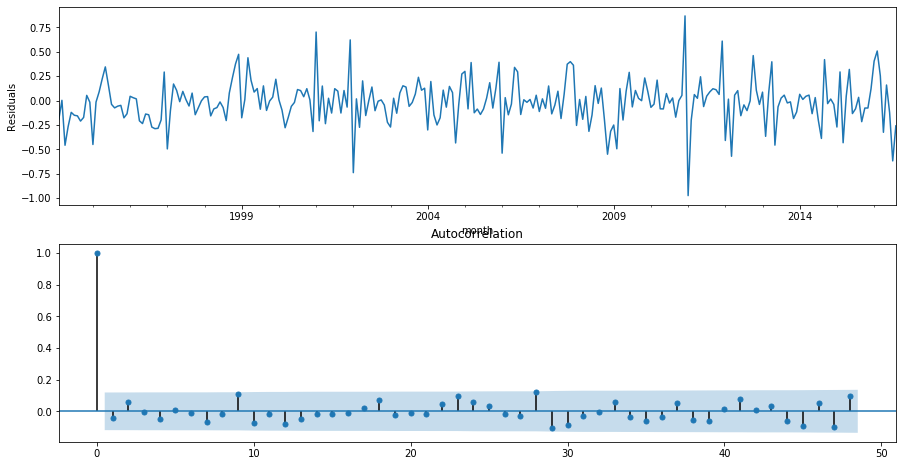

In [93]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [94]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

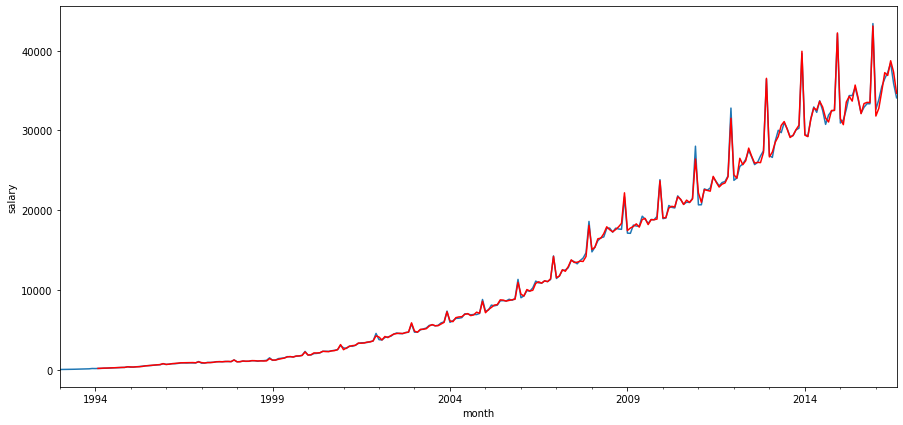

In [95]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

Итого: модель описывает данные в приемлемом качестве.



### Прогноз

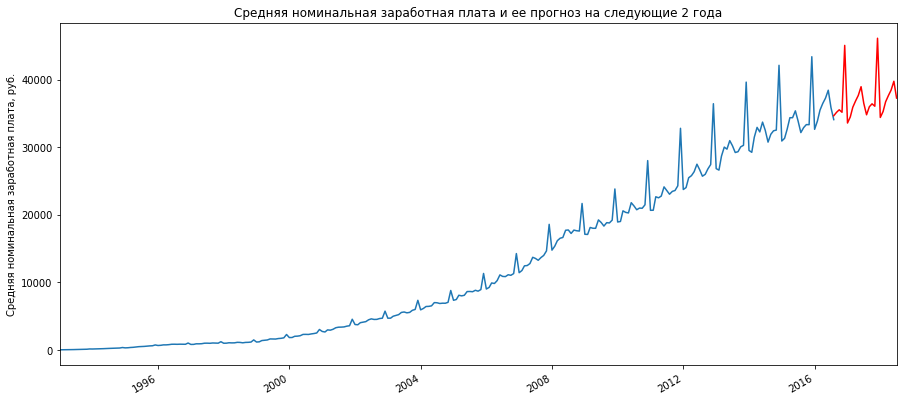

In [96]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=308), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.title(u'Средняя номинальная заработная плата и ее прогноз на следующие 2 года')
pylab.show()